In [1]:
import tomotopy as tp
import numpy as np
import pandas as pd
import re
import os
import time
import itertools
import konlpy
from kiwipiepy import Kiwi
from hanspell import spell_checker
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyLDAvis


In [2]:
df=pd.read_csv('leisure2.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})
df.info()

C:\Users\jenny\AppData\Local\Temp/ipykernel_12948/1705503032.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.read_csv('leisure2.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12029 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    12029 non-null  int64 
 1   real_date     12029 non-null  object
 2   year          12029 non-null  int64 
 3   month         12029 non-null  int64 
 4   type          10567 non-null  object
 5   review_title  12029 non-null  object
 6   review        12029 non-null  object
 7   score         12029 non-null  object
 8   dataset       11869 non-null  object
dtypes: int64(3), object(6)
memory usage: 845.9+ KB


In [3]:
df[df['dataset'].isnull()]

,Unnamed: 0,real_date,year,month,type,review_title,review,score,dataset
140,140,2015년 4월,2015,4,친구,경복궁 을 4월 2015,"전반적으로, 이 잘 유지되는 거리. 당신이 주변의 길 이 쉽게, 심지어는 표지판이 ...",4,NaN
146,146,2015년 4월,2015,4,가족,다른 관광지를 방문하는 데 pecfectly; 경복궁과 창덕궁,나와 내 가족은 매우 즐거운 방문입니다. 제가 한국에서 몇 년 전에 강한 느낌을 받...,5,NaN
523,523,2015년 9월,2015,9,개인,많은 메모리가 아닌 넓은 남아 있는,제가 처음에 이: 광화문. 이 그림같은 풍경을 사진도 가능합니다 도 두 섬을 가장 ...,4,NaN
527,527,2015년 9월,2015,9,가족,아름다운 궁전,부모님과 저는 한 달이 지난 수요일에 팰리스 입장료는 제도가! 우리는 전통적인 음악...,4,NaN
619,619,2015년 10월,2015,10,커플,아름다운 고대 궁전,"저희가 마지막 달의 하루는 수요일 지정된 배양물, 입구에 팰리스가 무료였습니다. 가...",5,NaN
...,...,...,...,...,...,...,...,...,...
11615,11616,2016년 7월,2016,7,친구,한국에 좋은 역사적인 소개,나는 친구와 함께 하는 시크릿 가든 투어 (1.5 시간 투어) 의 관점이 되는 만족...,4,NaN
11714,11715,2016년 10월,2016,10,커플,멋진 도시에 와,"저는, 서울을 방문하는 많은 복잡함. 궁전의 정원이 되었지만 여전히 바빴지만 및 방...",4,NaN
11756,11757,2016년 11월,2016,11,개인,잊을 수 없는 유네스코 문화 유산!,근처에 살고 있고. 저는 말 그대로 침대에 영어 가이드 투어를 잡기 위해 10:30...,5,NaN
11918,11919,2017년 6월,2017,6,커플,아름다운 정원,"저희 창덕궁 으로 시간이 10:30 인데 영어 투어, 투어 를 찾는 실제로 시작 1...",5,NaN


In [4]:
#결측치 데이터 지우기
df.dropna(subset=['dataset'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11869 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    11869 non-null  int64 
 1   real_date     11869 non-null  object
 2   year          11869 non-null  int64 
 3   month         11869 non-null  int64 
 4   type          10416 non-null  object
 5   review_title  11869 non-null  object
 6   review        11869 non-null  object
 7   score         11869 non-null  object
 8   dataset       11869 non-null  object
dtypes: int64(3), object(6)
memory usage: 927.3+ KB


In [5]:
import konlpy
stop_list=['우리','함께','있습니다']
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if not pos == 'Josa' and not pos =='Punctuation' and not pos =='Foreign' and len(word) > 1 and word not in stop_list :
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words

In [6]:
tokenized_list2 = []
a=df['dataset'].values
for text in range(len(a)):
    tokenized_list2.append(tokenize_korean_text(a[text]))

In [17]:
model = tp.DMRModel(k=20, alpha=0.1, eta=0.01, min_cf=3,rm_top=3,tw=tp.TermWeight.IDF)

key=df['score'].values
value=tokenized_list2


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass
        
               
model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 

Total docs: 11869
Total words: 309431
Vocab size: 7469


==== Coherence : c ====
Average: 0.3526660437649116 
Per Topic: [0.3191457372158766, 0.375888542458415, 0.3831184670329094, 0.31084034591913223, 0.36456538438797, 0.2732575533911586, 0.42751105725765226, 0.3669418290257454, 0.38836834728717806, 0.3602231562137604, 0.34220774918794633, 0.3498948965221643, 0.3495117388665676, 0.3465816043317318, 0.3438780913129449, 0.3759137228131294, 0.3886992081999779, 0.2982480417005718, 0.32395573519170284, 0.36456966698169707]


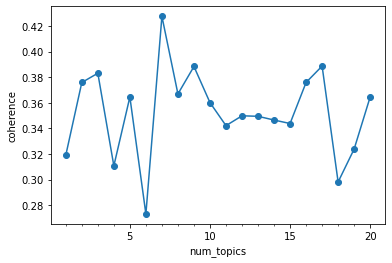

In [18]:
# calculate coherence using preset
ax=plt.axes()
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence : c ====')
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
x=range(1,21,1)
plt.plot(x, coherence_per_topic,marker='o')
plt.xlabel("num_topics")
plt.ylabel("coherence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()
print()

위 결과에서 7개일 때 가장 높은 응집도를 보였기 때문에 토픽을 7개로 설정하였다.

In [19]:
model = tp.DMRModel(k=7 , alpha=0.1, eta=0.01, min_df=3,rm_top=3,tw=tp.TermWeight.IDF)

key=df['score'].values
value=tokenized_list2


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass

model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
 
 
for i in range(200):
    model.train(1)
    
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Total docs: 11869
Total words: 309071
Vocab size: 7354
Topic #0	투어, 궁전, 가이드, 가든, 정원, 시크릿, 팰리스, 역사, 사원, 아름다운
Topic #1	건물, 디자인, 쇼핑, 마을, 전통, 지역, 사진, 거리, 대학, 북촌
Topic #2	도시, 산책, 아름다운, 많은, 스트림, 따라, 시간, 공원, 방문, 아주
Topic #3	입어, 아름다운, 방문, 궁전, 사진, 시간, 전통, 한국, 팰리스, 사람
Topic #4	궁전, 방문, 역사, 한국, 시간, 팰리스, 건물, 하는, 투어, 아름다운
Topic #5	타워, 전망, 케이블카, 타고, 버스, 멋진, 남산, 도시, 사랑, 풍경
Topic #6	한강, 좋아요, 공원, 너무, 야경, 산책, 도심, 입니다, 좋습니다, 자전거


In [20]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 11869 docs, 309071 words
| Total Vocabs: 20451, Used Vocabs: 7354
| Entropy of words: 7.26963
| Entropy of term-weighted words: 7.91900
| Removed Vocabs: 있는 좋은 서울
| Metadata of docs and its distribution
|  5: 5961
|  3: 1301
|  4: 4422
|  2: 141
|  1: 44
|
<Training Info>
| Iterations: 200, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.80841
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 0 (minimum collection frequency of words)
| min_df: 3 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 7 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of nor

In [21]:
#감성점수 계산
print('Topic distributions by score')

df2=pd.DataFrame()
score_labels=['1','2','3','4','5']
for i in score_labels:
    df2[i+'score']=model.get_topic_prior(i)
df2['total']=df2.sum(axis=1)

total_sum=df2['total'].values
gamsung_sum=0
gamsung_list=[]
for i in range(model.k):
    a=df2.iloc[i,:-1].values
    gamsung_sum=(a[0]*1+a[1]*2+a[2]*3+a[3]*4+a[4]*5)/total_sum[i]
    gamsung_list.append(gamsung_sum)
    
df2['re_score']=gamsung_list
df2=df2.round(3)
df2.head(20)

Topic distributions by score


,1score,2score,3score,4score,5score,total,re_score
0,0.050,0.031,0.014,0.023,0.097,0.215,3.394
1,0.466,0.077,0.055,0.095,0.030,0.723,1.820
2,0.021,0.049,0.017,0.030,0.066,0.183,3.389
3,0.044,0.076,0.004,0.008,0.027,0.159,2.363
4,0.199,0.179,0.010,0.041,0.025,0.454,1.932
5,0.034,0.024,0.047,0.063,0.042,0.211,3.263
6,0.050,0.908,0.055,0.055,0.046,1.115,2.228


In [22]:
#각 토픽 별 상위 10개 단어 추출
word_list=[]
for i in range(model.k):
    a=model.get_topic_words(i, top_n=10)
    word_list.append([x[0] for x in a])

df2['word_list']=word_list
df2.head(15)

,1score,2score,3score,4score,5score,total,re_score,word_list
0,0.050,0.031,0.014,0.023,0.097,0.215,3.394,"[투어, 궁전, 가이드, 가든, 정원, 시크릿, 팰리스, 역사, 사원, 아름다운]"
1,0.466,0.077,0.055,0.095,0.030,0.723,1.820,"[건물, 디자인, 쇼핑, 마을, 전통, 지역, 사진, 거리, 대학, 북촌]"
2,0.021,0.049,0.017,0.030,0.066,0.183,3.389,"[도시, 산책, 아름다운, 많은, 스트림, 따라, 시간, 공원, 방문, 아주]"
3,0.044,0.076,0.004,0.008,0.027,0.159,2.363,"[입어, 아름다운, 방문, 궁전, 사진, 시간, 전통, 한국, 팰리스, 사람]"
4,0.199,0.179,0.010,0.041,0.025,0.454,1.932,"[궁전, 방문, 역사, 한국, 시간, 팰리스, 건물, 하는, 투어, 아름다운]"
5,0.034,0.024,0.047,0.063,0.042,0.211,3.263,"[타워, 전망, 케이블카, 타고, 버스, 멋진, 남산, 도시, 사랑, 풍경]"
6,0.050,0.908,0.055,0.055,0.046,1.115,2.228,"[한강, 좋아요, 공원, 너무, 야경, 산책, 도심, 입니다, 좋습니다, 자전거]"


In [23]:
 # extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=5, min_df=5, max_len=5, max_cand=10000, normalized=True)
cands = extractor.extract(model)

labeler = tp.label.FoRelevance(model, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(model.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 투어, 가이드, 영어, 팰리스, 가이드 투어
투어	0.01581452786922455
궁전	0.01337477844208479
가이드	0.012412103824317455
가든	0.010645356960594654
정원	0.010240714065730572
시크릿	0.009879541583359241
팰리스	0.00975580420345068
역사	0.009521860629320145
사원	0.008229977451264858
아름다운	0.007240865845233202

== Topic #1 ==
Labels: 건물, 관광 정보 센터, 상점, 상점 같은, 디자인
건물	0.01111744437366724
디자인	0.00988629087805748
쇼핑	0.008328014053404331
마을	0.008244132623076439
전통	0.008129416033625603
지역	0.006805751472711563
사진	0.006437044590711594
거리	0.005941976793110371
대학	0.005767020862549543
북촌	0.005720228422433138

== Topic #2 ==
Labels: 있는, 모든, 많은, 시간, 경우
도시	0.0069550396874547005
산책	0.00623643072322011
아름다운	0.005538358818739653
많은	0.005483114160597324
스트림	0.0053633530624210835
따라	0.004886162932962179
시간	0.004781654570251703
공원	0.004726035986095667
방문	0.004610917530953884
아주	0.0046082125045359135

== Topic #3 ==
Labels: 민속 박물관 방문, 시작 되었다, 관광객 주민, 이벤, 야드
입어	0.008104830048978329
아름다운	0.0073910546489059925
방문	0.0073001454584300

In [24]:
df3=pd.DataFrame()
df3['docs']=tokenized_list2
df3['score']=df['score'].values
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11869 entries, 0 to 11868
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docs    11869 non-null  object
 1   score   11869 non-null  object
dtypes: object(2)
memory usage: 185.6+ KB


In [25]:
#빈도 구하기

topic_num=[]
temp1=[] #토픽번호
temp2=[] #분포율
for i in range(len(model.docs)):
    a=model.docs[i].get_topics()
    temp1.append([x[0] for x in a])
    temp2.append([x[1] for x in a])
for i in range(len(temp1)):
    if temp2[i][0] >= 0.5:
        topic_num.append(temp1[i][0])
    else :
        topic_num.append(np.NaN)

In [26]:
df3['topic_num']=topic_num
df3[df3['topic_num'].isnull()]

,docs,score,topic_num
6,"[궁전, 지하철역, 쉽게, 걸어갈, 있는, 베이징, 있는, 자금성, 경우, 궁전, ...",4,NaN
9,"[한국, 좋은, 문화, 상징, 장소, 소개, 가족, 즐겼다, 덕분, 아주, 재미있는...",5,NaN
14,"[반사, 국가, 경복궁, 결정, 화요일, 휴무, 입니다, 그것, 완벽한, 중앙, 있...",3,NaN
19,"[확인, 경우, 관광, 궁전, 보려면, 칠한, 건물, 세부, 사항, 이러한, 점심,...",3,NaN
43,"[가장, 흥미로운, 팰리스, 분명히, 가지, 가보세요, 서울, 만일, 기념물, 살았...",4,NaN
...,...,...,...
11787,"[매력, 장소, 방문, 창덕궁, 매력, 장소, 방문, 아키텍처, 비밀, 정원, 하는...",5,NaN
11792,"[마음, 정돈, 되는, 도시, 있는, 도시, 잠시, 열어, 줍니다, 생활, 입장료,...",5,NaN
11802,"[창덕궁, 후원, 무병장수, 창덕궁, 후원, 창덕궁, 입장, 이외, 추가, 입장료,...",4,NaN
11808,"[서울, 명궁, 가장, 가치, 있는, 궁일, 시간, 맞춰가면, 설명, 주는, 설명,...",5,NaN


In [27]:
df4=df3.groupby(['topic_num','score'])['docs']
print(df4.size().reset_index(name='counts'))

    topic_num score  counts
0         0.0     1       1
1         0.0     2       3
2         0.0     3      71
3         0.0     4     401
4         0.0     5     709
5         1.0     1       1
6         1.0     2      11
7         1.0     3     118
8         1.0     4     348
9         1.0     5     324
10        2.0     1       4
11        2.0     2      11
12        2.0     3     134
13        2.0     4     484
14        2.0     5     785
15        3.0     2       1
16        3.0     3      15
17        3.0     4     130
18        3.0     5     178
19        4.0     1       7
20        4.0     2      19
21        4.0     3     150
22        4.0     4     388
23        4.0     5     453
24        5.0     1      15
25        5.0     2      33
26        5.0     3     324
27        5.0     4     894
28        5.0     5     844
29        6.0     1      10
30        6.0     2      39
31        6.0     3     322
32        6.0     4    1291
33        6.0     5    2042
